In [2]:
from workingcondition import WorkingCondition, OneDSettings

import cantera as ct
import numpy as np

import math
from tabulate import tabulate, SEPARATING_LINE
tabulate.PRESERVE_WHITESPACE = True


In [3]:

# ================================================================================
# Sampling Setup
# ================================================================================
# Mechanism files should be put into /your/path/miniconda3/envs/your_env/lib/python3.8/site-packages/cantera/data/

mechanism                   =   'Okafor26_noCO2.yaml'
air                         =   "O2:0.21,N2:0.79"
T_inlet                     =   300
p                           =   ct.one_atm

primary_fuel                =   "NH3"
secondary_fuel              =   ""          #  use "" if single fuel
diluent_name                =   ""             #  use "" if no diluent
inert_specie                =   "AR"

CFD_dT                      =   5e-7
num_mesh_cells              =   500            #  number of mesh cells in 1d-flame simulation
sampling_number             =   100            #  number of sampled times in 1d-flame simulation
sampling_temperature        =   T_inlet + 10

blending_ratio_values       =   np.linspace(0.0, 0.6, 4) if secondary_fuel != "" else [1.0]
equiv_ratio_values          =   np.linspace(0.45, 3.0, 52)
# equiv_ratio_values          =   np.arange(0.8, 1.0, 0.05)

ratio_digit_ctrl            =   3
fuel_composition_digit_ctrl =   3

dilution_mole               =   0.1


In [4]:

# ================================================================================

def my_trunc(number, digits):
    """Truncates a number to a specified number of decimal digits."""
    stepper = np.power(10, digits)
    return np.trunc(stepper * number) / stepper


        
        


In [5]:

# ================================================================================

one_d_settings = OneDSettings(
    mechanism,
    inert_specie,
    CFD_dT,
    num_mesh_cells
)

fuel = primary_fuel if secondary_fuel == "" else primary_fuel+" & "+secondary_fuel

if len(blending_ratio_values) >= 6:
    blending_ratio_values_str = f"From {blending_ratio_values[0]:.3f} to {blending_ratio_values[-1]:.3f} with interval of {(blending_ratio_values[1]-blending_ratio_values[0]):.3f}" if secondary_fuel != "" else "-"
else:
    blending_ratio_values_str = "[ "+', '.join(f'{value:.3f}' for value in blending_ratio_values)+" ]"
blending_ratio_table_val = f"{len(blending_ratio_values)} values in total" if secondary_fuel != "" else "-"

if len(equiv_ratio_values) >= 6:
    equiv_ratio_values_str = f"From {equiv_ratio_values[0]:.3f} to {equiv_ratio_values[-1]:.3f} with interval of {(equiv_ratio_values[1]-equiv_ratio_values[0]):.3f}"
else:
    equiv_ratio_values_str = "[ "+', '.join(f'{value:.3f}' for value in equiv_ratio_values)+" ]"

table = [['Mechanism', mechanism, ''],
         ['Fuel', fuel, ''],
         SEPARATING_LINE,
         ['Temperature', f"{T_inlet:.0f}", "K"],
         ['Pressure', f"{p:.0f}", "Pa"],
         ['Blending Ratio', blending_ratio_values_str, blending_ratio_table_val],
         ['Equivalence Ratio', equiv_ratio_values_str, f"{len(equiv_ratio_values)} values in total"],
         SEPARATING_LINE,
         ['Simulation Time Step', f"{CFD_dT:.0e}", "s"],
         ['Minimum Sampling Temperature', f"{sampling_temperature:.0f}", "K"],]
print(tabulate(table, tablefmt="rst", colalign=("left","right", "left")))

# ================================================================================


============================  ==========================================  ==================
Mechanism                                            Okafor26_noCO2.yaml
Fuel                                                                 NH3
============================  ==========================================  ==================
Temperature                                                          300  K
Pressure                                                          101325  Pa
Blending Ratio                                                 [ 1.000 ]  -
Equivalence Ratio             From 0.450 to 3.000 with interval of 0.050  52 values in total
============================  ==========================================  ==================
Simulation Time Step                                               5e-07  s
Minimum Sampling Temperature                                         310  K
============================  ==========================================  ==================


In [6]:

case_list = []

case_count = 0

for blending_ratio in blending_ratio_values:
    for equiv_ratio in equiv_ratio_values:
        case_count +=1
        
        # if secondary_fuel == "" :
        #     fuel_composition = primary_fuel+":1"
        # elif diluent_name == "" :  
        #     fuel_composition = primary_fuel+f":{blending_ratio:.{fuel_composition_digit_ctrl}f},"\
        #                         +secondary_fuel+f":{1-blending_ratio:.{fuel_composition_digit_ctrl}f}"
        # else:
        #     fuel_composition = primary_fuel+f":{blending_ratio/(1+dilution_mole):.{fuel_composition_digit_ctrl}f},"\
        #                         +secondary_fuel+f":{(1-blending_ratio)/(1+dilution_mole):.{fuel_composition_digit_ctrl}f},"\
        #                         +diluent_name+f":{dilution_mole/(1+dilution_mole):.{fuel_composition_digit_ctrl}f}"

        fuel_composition = 'NH3:40,H2:45,N2:15'
        
        case = WorkingCondition(
            one_d_settings,
            case_count,
            mechanism,
            T_inlet,
            p,
            fuel_composition,
            air,
            equiv_ratio
        )
        
        LFS, thickness = case.calculate_flame_speed()
        
        case_list.append(case)


Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...
Solving...


In [12]:
        
laminar_flame_speeds = np.array([case.laminar_flame_speed for case in case_list])
flame_thicknesses = np.array([case.laminar_flame_thickness for case in case_list])

domain_sizes = np.trunc((flame_thicknesses * 511 / 10) * 1000) / 1000

turbulent_velocity = 2
num_vortex = 10

turbulent_length_scales = domain_sizes / num_vortex

y = turbulent_velocity / laminar_flame_speeds
x = turbulent_length_scales / flame_thicknesses

Re = x * y
Ka = (x**-0.5) * (y**1.5)

print("\n\n")

table = []
headers = [
    'Fuel Comp.', 
    'E.R. \n[-]', 
    'L.F.S. \n[mm/s]',
    'T.V. \n[m/s]', 
    'y \n[-]',
    'L.F.T. \n[mm]', 
    'D.S. \n[mm]', 
    'T.L.S. \n[mm]', 
    'x \n[-]',
    'Re \n[-]', 
    'Ka \n[-]'
]

for i, case in enumerate(case_list):
    table.append([
        case.fuel_composition,
        f"{case.equivalence_ratio:.2f}",
        f"{case.laminar_flame_speed*1000:.2f}",
        f"{turbulent_velocity:.0f}",
        f"{y[i]:.2f}",
        f"{case.laminar_flame_thickness*1000:.2f}",
        f"{domain_sizes[i]*1000:.0f}",
        f"{turbulent_length_scales[i]*1000:.2f}",
        f"{x[i]:.2f}",
        f"{Re[i]:.2f}",
        f"{Ka[i]:.2f}"
    ])

table_align_fmt = ("left", "right", "right", "right", "right", "right", "right", "right", "right", "right", "right")
print(tabulate(table, headers, tablefmt="simple", colalign=table_align_fmt, disable_numparse=True))

# print(Re)
# print(Ka) 






Fuel Comp.            E.R.     L.F.S.     T.V.      y     L.F.T.     D.S.     T.L.S.      x      Re      Ka
                        [-]     [mm/s]    [m/s]    [-]       [mm]     [mm]       [mm]    [-]     [-]     [-]
------------------  -------  ---------  -------  -----  ---------  -------  ---------  -----  ------  ------
NH3:40,H2:45,N2:15     0.45      21.45        2  93.25       4.48      228      22.80   5.09  475.07  398.96
NH3:40,H2:45,N2:15     0.50      41.14        2  48.61       2.51      128      12.80   5.09  247.62  150.16
NH3:40,H2:45,N2:15     0.55      65.25        2  30.65       1.72       87       8.70   5.07  155.43   75.37
NH3:40,H2:45,N2:15     0.60      92.92        2  21.52       1.30       66       6.60   5.09  109.65   44.25
NH3:40,H2:45,N2:15     0.65     120.49        2  16.60       1.07       54       5.40   5.05   83.85   30.09
NH3:40,H2:45,N2:15     0.70     147.39        2  13.57       0.93       47       4.70   5.04   68.43   22.26
NH3:40,H2:45,N2:1

0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.8999999999999999
0.95
1.0
1.05
1.0999999999999999
1.15
1.2
1.25
1.3
1.3499999999999999
1.4
1.45
1.4999999999999998
1.5499999999999998
1.5999999999999999
1.65
1.7
1.7499999999999998
1.7999999999999998
1.8499999999999999
1.9
1.9499999999999997
1.9999999999999998
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.4499999999999997
2.5
2.55
2.6
2.65
2.7


Text(0, 0.5, 'Turb. Velocity/Lami. Flame Speed')

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

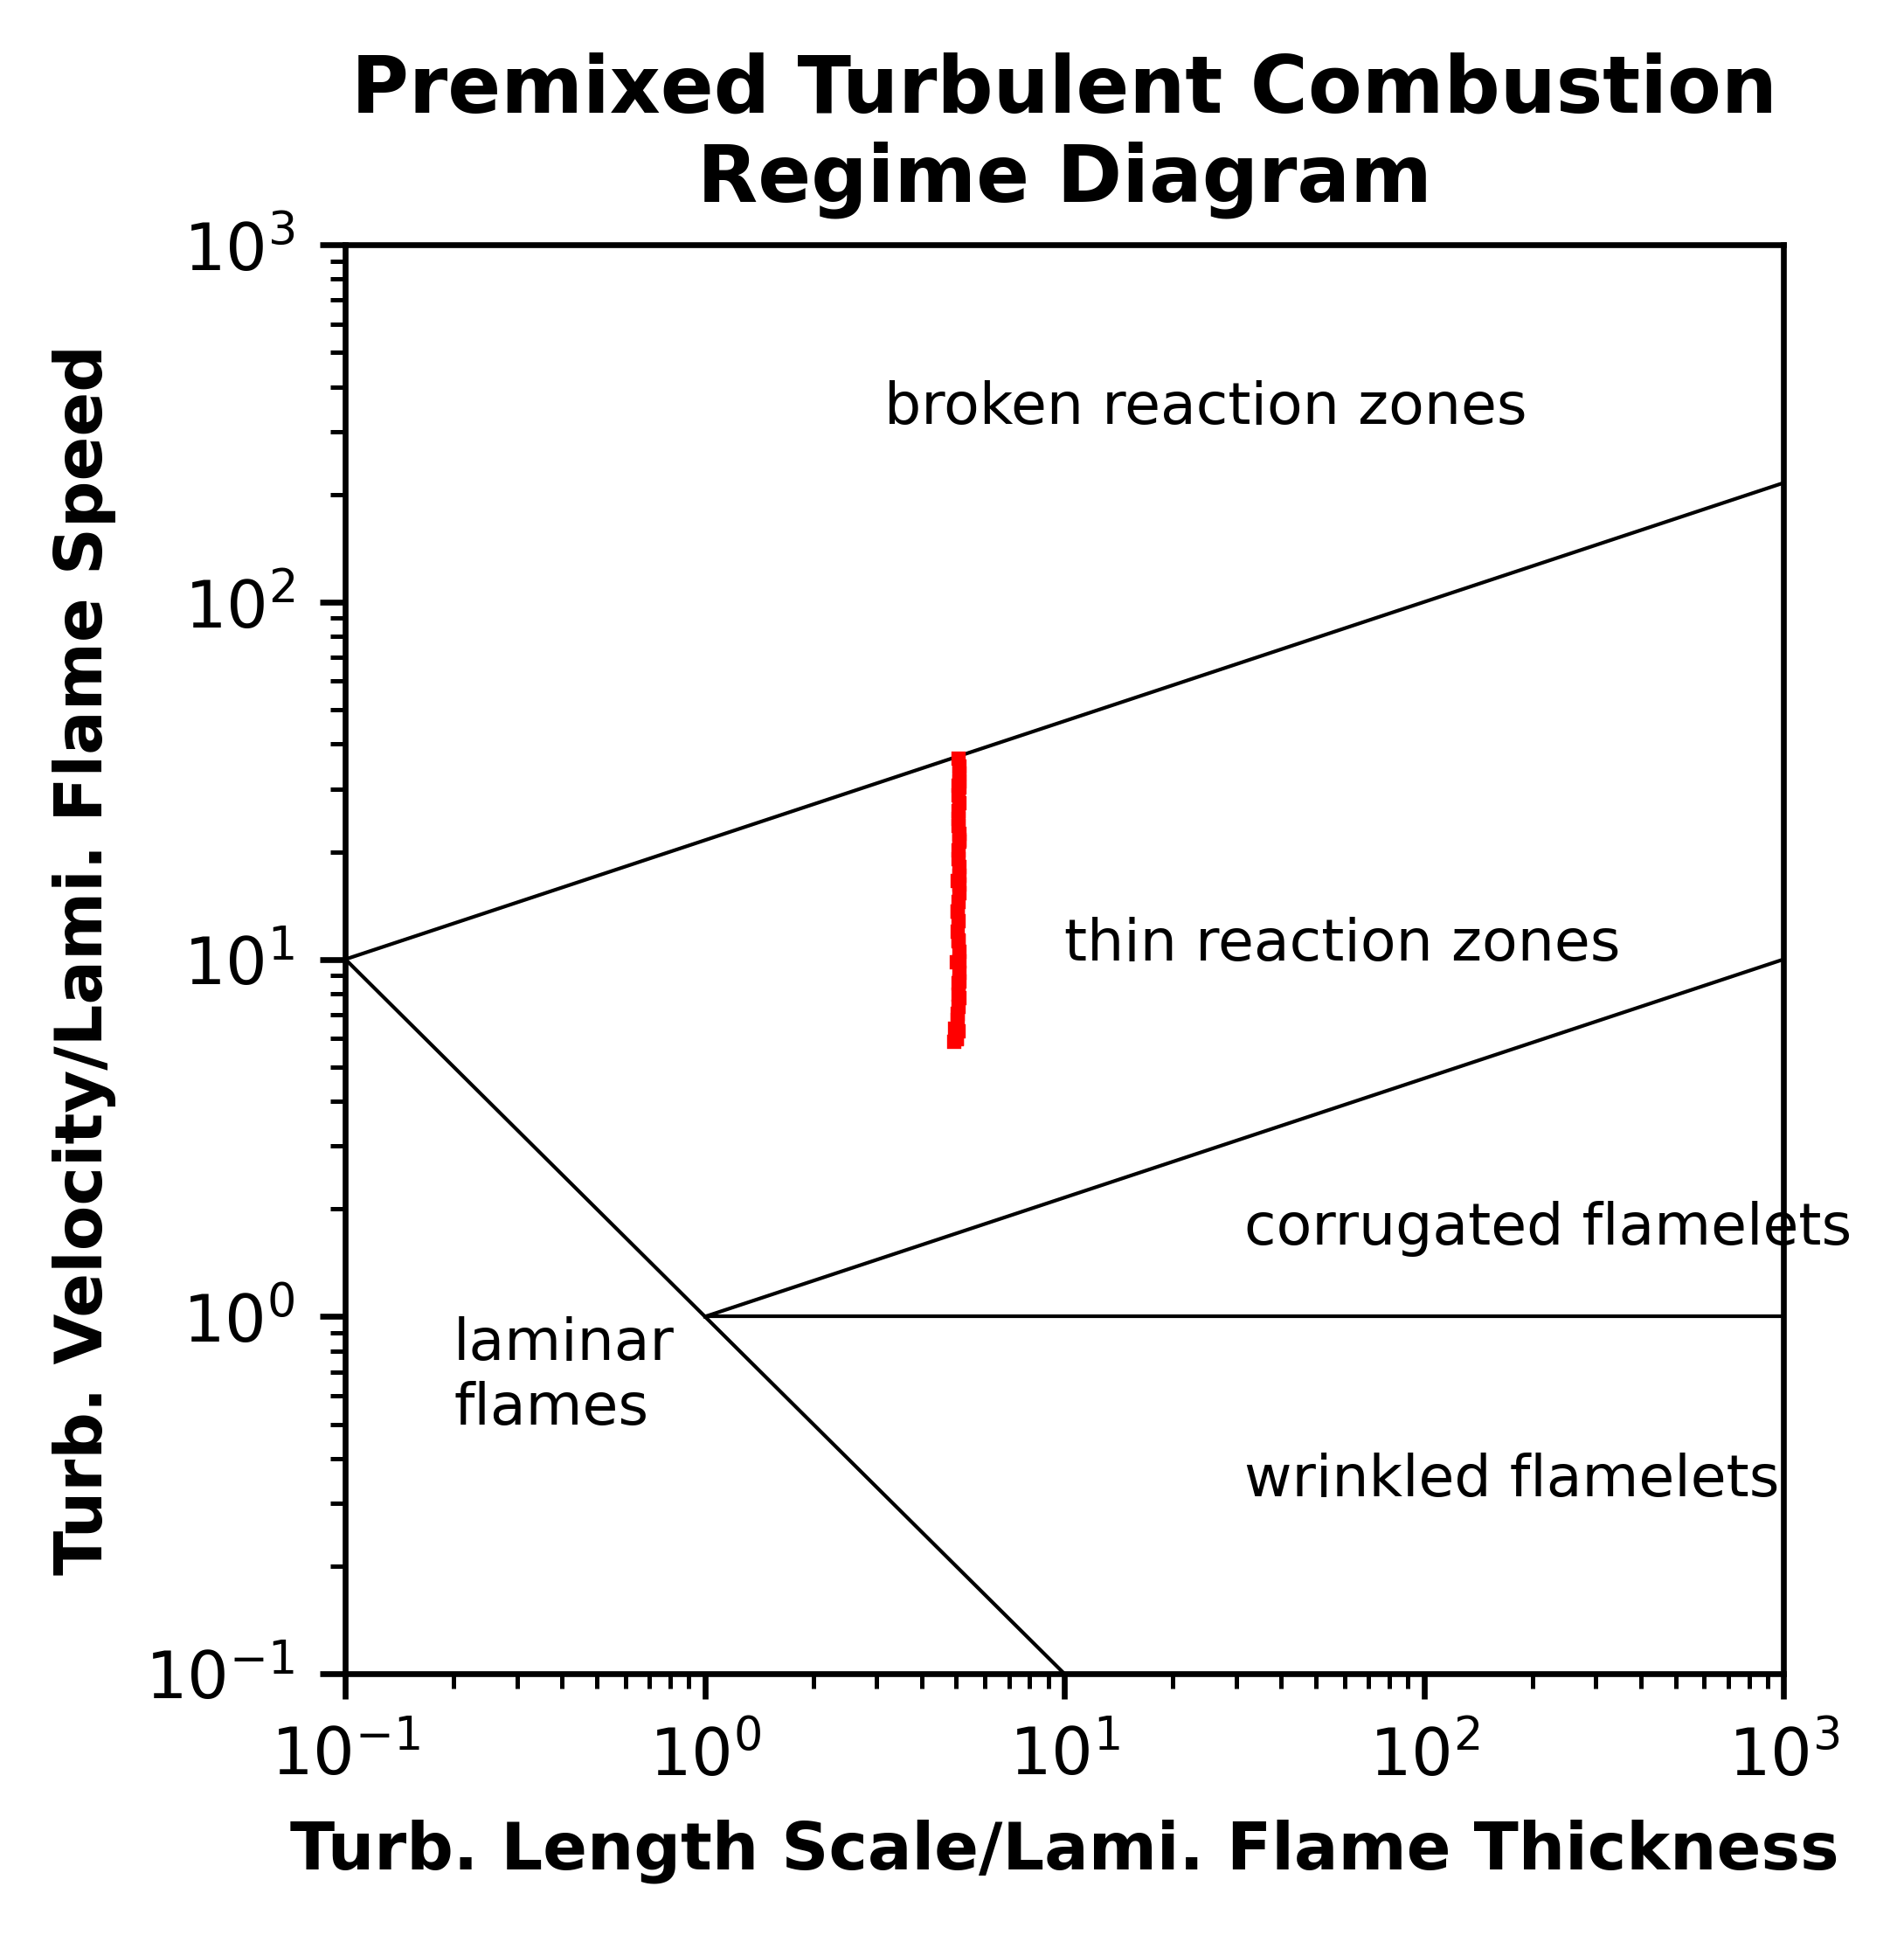

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 9

fig, ax = plt.subplots(1, 1, figsize=(3.54, 3.54), dpi=600)

delta = 0.1
Ka_delta_at_1000 = (1/delta**2*1000**0.5)**(2/3)

ax.plot([0.1, 10],[10, 0.1],color='k',lw=0.5)
ax.plot([0.1, 1000],[10, Ka_delta_at_1000],color='k',lw=0.5)
ax.plot([1, 1000],[1, 10],color='k',lw=0.5)
ax.plot([1, 1000],[1, 1],color='k',lw=0.5)

for i, case in enumerate(case_list):
    if Ka[i] > 1/delta**2:
        # ax.plot(x[i], y[i], 'bs', markersize=1)
        pass
    else:
        ax.plot(x[i], y[i], 'rs', markersize=1)
        print(case.equivalence_ratio)

ax.text(10, 10, "thin reaction zones", fontsize=8)
ax.text(31.6, 1.6, "corrugated flamelets", fontsize=8)
ax.text(31.6, 0.316, "wrinkled flamelets", fontsize=8)
ax.text(3.16, 316, "broken reaction zones", fontsize=8)
ax.text(0.2, 0.5, "laminar\nflames", fontsize=8)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(0.1, 1000)
ax.set_ylim(0.1, 1000)
ax.set_title("Premixed Turbulent Combustion\nRegime Diagram",fontweight='bold')
ax.set_xlabel("Turb. Length Scale/Lami. Flame Thickness",fontweight='bold')
ax.set_ylabel("Turb. Velocity/Lami. Flame Speed",fontweight='bold')
